<a href="https://colab.research.google.com/github/RAAHUL-tech/LLM_Research/blob/main/PTQ_vs_QAT_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% [code]
!pip -q install datasets safetensors accelerate sentencepiece

import math, time, os, io, json, random, functools, gc, copy
from dataclasses import dataclass, asdict
from typing import Optional, Tuple, Dict, Any, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from safetensors.torch import save_file as save_safetensors

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

os.makedirs("/content/quant_results/checkpoints", exist_ok=True)
os.makedirs("/content/quant_results/plots", exist_ok=True)
SEED = 1337
torch.manual_seed(SEED); random.seed(SEED)


Device: cuda


In [2]:
# %% [code]
"""
We prefer a sentencepiece tokenizer for TinyStories/WikiText.
If unavailable, we fall back to a byte-level tokenizer (simple).
"""

from transformers import AutoTokenizer

def get_tokenizer():
    # Use a small LLaMA-compatible tokenizer (llama-3-like)
    # If it fails, use gpt2 tokenizer (byte-level, robust).
    candidates = [
        "fxmarty/tiny-llama-fast-tokenizer",
        "openai-community/gpt2"  # fallback (byte-level)
    ]
    for name in candidates:
        try:
            tok = AutoTokenizer.from_pretrained(name, use_fast=True)
            if tok.pad_token is None:
                tok.pad_token = tok.eos_token or "<|pad|>"
            return tok
        except Exception as e:
            print(f"Tokenizer {name} not available:", e)
    raise RuntimeError("No tokenizer available.")

tokenizer = get_tokenizer()
vocab_size = tokenizer.vocab_size
print("Vocab size:", vocab_size, "pad:", tokenizer.pad_token_id, "eos:", tokenizer.eos_token_id)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


Vocab size: 32000 pad: 2 eos: 2


In [3]:
# %% [code]
MAX_TOKENS = 256  # sequence length for training/eval
BATCH_SIZE = 16 if device=="cuda" else 4
NUM_EVAL_SAMPLES = 4096  # for quick perplexity eval; increase for stronger signal

def tokenize_function(examples, field):
    text = examples[field] if isinstance(examples[field], list) else [examples[field]]
    out = tokenizer(
        text, truncation=True, padding="max_length",
        max_length=MAX_TOKENS, return_tensors=None
    )
    return {"input_ids": out["input_ids"]}

def build_tinystories(split="train"):
    ds = load_dataset("roneneldan/TinyStories", split=split)
    # Use "text" field
    ds = ds.map(lambda x: tokenize_function(x, "text"), batched=True, remove_columns=ds.column_names)
    ds.set_format(type="torch", columns=["input_ids"])
    return ds

def build_wikitext(split="test"):
    ds = load_dataset("wikitext", "wikitext-2-raw-v1", split=split)
    ds = ds.map(lambda x: tokenize_function(x, "text"), batched=True, remove_columns=ds.column_names)
    ds.set_format(type="torch", columns=["input_ids"])
    return ds

train_ds = build_tinystories("train[:25%]")   # small slice for speed; increase as needed
val_ds   = build_tinystories("train[25%:30%]") # small val split
test_wt2 = build_wikitext("test")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print("TinyStories train/val sizes:", len(train_ds), len(val_ds))
print("WikiText-2 test size:", len(test_wt2))


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Map:   0%|          | 0/529930 [00:00<?, ? examples/s]

Map:   0%|          | 0/105986 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

TinyStories train/val sizes: 529930 105986
WikiText-2 test size: 4358


In [4]:
# %% [code]
@dataclass
class ModelConfig:
    vocab_size: int
    n_layer: int = 8
    n_head: int = 8
    d_model: int = 512
    d_ff: int = 4*512
    dropout: float = 0.0
    rope_theta: float = 10000.0
    max_seq_len: int = MAX_TOKENS

class RotaryEmbedding(nn.Module):
    def __init__(self, dim, theta=10000.0):
        super().__init__()
        inv_freq = 1.0 / (theta ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, x, seq_dim=-2):
        # x: [..., seq_len, dim]
        t = torch.arange(x.size(seq_dim), device=x.device, dtype=self.inv_freq.dtype)
        freqs = torch.einsum("i,j->ij", t, self.inv_freq) #outer product → shape [seq_len, dim/2]
        emb = torch.cat((freqs, freqs), dim=-1)
        cos = emb.cos().unsqueeze(0).unsqueeze(0)  # [1,1,seq,dim]
        sin = emb.sin().unsqueeze(0).unsqueeze(0)
        return cos, sin

def apply_rope(x, cos, sin):
    # x: [B, n_head, seq, head_dim]
    x1, x2 = x[..., ::2], x[..., 1::2]   # even and odd dims
    x_rot = torch.stack((-x2, x1), dim=-1).reshape_as(x) # rotate pairs
    return x * cos + x_rot * sin

class MHA(nn.Module):
    def __init__(self, d_model, n_head, dropout=0.0, rope_theta=10000.0):
        super().__init__()
        assert d_model % n_head == 0
        self.n_head = n_head
        self.head_dim = d_model // n_head
        self.qkv = nn.Linear(d_model, 3*d_model, bias=False)
        self.proj = nn.Linear(d_model, d_model, bias=False)
        self.drop = nn.Dropout(dropout)
        self.rope = RotaryEmbedding(self.head_dim, theta=rope_theta)

    def forward(self, x, attn_mask=None):
        B, S, C = x.shape
        qkv = self.qkv(x).view(B, S, 3, self.n_head, self.head_dim).transpose(1,2)  # [B,3,S,H,D]
        q, k, v = qkv[:,0], qkv[:,1], qkv[:,2]  # [B,S,H,D]

        q = q.transpose(1,2)  # [B,H,S,D]
        k = k.transpose(1,2)
        v = v.transpose(1,2)

        cos, sin = self.rope(q)
        q = apply_rope(q, cos, sin)
        k = apply_rope(k, cos, sin)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B,H,S,S]
        if attn_mask is not None:
            att = att + attn_mask
        att = F.softmax(att, dim=-1)
        att = self.drop(att)
        y = att @ v  # [B,H,S,D]
        y = y.transpose(1,2).contiguous().view(B, S, -1)
        y = self.proj(y)
        y = self.drop(y)
        return y

class MLP(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.act = nn.SiLU()
        self.fc2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        return self.drop(self.fc2(self.act(self.fc1(x))))

class Block(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(cfg.d_model)
        self.attn = MHA(cfg.d_model, cfg.n_head, cfg.dropout, cfg.rope_theta)
        self.ln2 = nn.LayerNorm(cfg.d_model)
        self.mlp = MLP(cfg.d_model, cfg.d_ff, cfg.dropout)

    def forward(self, x, attn_mask):
        x = x + self.attn(self.ln1(x), attn_mask)
        x = x + self.mlp(self.ln2(x))
        return x

class TinyLLaMA(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.cfg = cfg
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.blocks = nn.ModuleList([Block(cfg) for _ in range(cfg.n_layer)])
        self.ln_f = nn.LayerNorm(cfg.d_model)
        self.lm_head = nn.Linear(cfg.d_model, cfg.vocab_size, bias=False)

        # Causal mask precompute
        S = cfg.max_seq_len
        mask = torch.full((1,1,S,S), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        self.register_buffer("attn_mask", mask, persistent=False)

    def forward(self, idx):
        # idx: [B, S]
        B, S = idx.shape
        x = self.tok_emb(idx)
        attn_mask = self.attn_mask[:, :, :S, :S]
        for blk in self.blocks:
            x = blk(x, attn_mask)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

    #auto regressive loop
    @torch.no_grad()
    def generate(self, idx, max_new_tokens=64, temperature=1.0, top_k=None):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.cfg.max_seq_len:]
            logits = self(idx_cond)[:, -1, :]
            if temperature != 1.0:
                logits /= temperature
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float("Inf")
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_id], dim=1)
        return idx

def count_params(m): return sum(p.numel() for p in m.parameters())


In [5]:

# %% [code]
def build_model(size="S"):
    """
    Presets:
      S  ~ 40M params (fast on Colab T4)
      M  ~ 125M params (ok on A100 / longer on T4)
    """
    if size == "M":
        cfg = ModelConfig(vocab_size=vocab_size, n_layer=12, n_head=12, d_model=768, d_ff=3072)
    else:
        cfg = ModelConfig(vocab_size=vocab_size, n_layer=8, n_head=8, d_model=512, d_ff=2048)
    model = TinyLLaMA(cfg).to(device)
    print(f"Model size {size}: {count_params(model)/1e6:.1f}M params")
    return model

@torch.no_grad()
def eval_perplexity(model, loader, max_tokens_eval=NUM_EVAL_SAMPLES):
    model.eval()
    total, n = 0.0, 0
    tokens_seen = 0
    for batch in loader:
        x = batch["input_ids"].to(device)
        logits = model(x)
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = x[:, 1:].contiguous()
        loss = F.cross_entropy(shift_logits.view(-1, logits.size(-1)), shift_labels.view(-1), reduction="mean")
        total += loss.item()
        n += 1
        tokens_seen += x.numel()
        if tokens_seen >= max_tokens_eval: break
    ppl = math.exp(total / max(1, n)) #total / n: average loss per batch.
    return ppl

@torch.no_grad()
def measure_throughput(model, seq_len=MAX_TOKENS, steps=50, warmup=10):
    model.eval()
    x = torch.randint(0, vocab_size, (1, seq_len), device=device)
    times = []
    # Greedy generation 1 token/step
    for i in range(steps+warmup):
        t0 = time.time()
        logits = model(x)[:, -1, :]
        next_id = torch.argmax(logits, dim=-1, keepdim=True)
        x = torch.cat([x, next_id], dim=1)[:, -seq_len:]
        if i >= warmup:
            times.append(time.time()-t0)
    tok_per_s = 1.0 / (sum(times)/len(times)) #(sum(times)/len(times)) = average time per token; 1.0 / ... = tokens per second.
    return tok_per_s

def train_finetune(model, train_loader, val_loader, steps=500, lr=3e-4, log_every=50):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler('cuda', enabled=(device=="cuda")) #Sets up automatic mixed precision (AMP) gradient scaling to prevent underflow when training in float16
    losses = []
    it = iter(train_loader)
    for step in range(1, steps+1):
        try:
            batch = next(it)
        except StopIteration:
            it = iter(train_loader)
            batch = next(it)
        x = batch["input_ids"].to(device)
        with torch.amp.autocast('cuda', enabled=(device=="cuda")):
            logits = model(x)
            loss = F.cross_entropy(logits[:, :-1].contiguous().view(-1, logits.size(-1)),
                                   x[:, 1:].contiguous().view(-1), reduction="mean")
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
        losses.append(loss.item())
        if step % log_every == 0:
            val_ppl = eval_perplexity(model, val_loader, max_tokens_eval=4096)
            print(f"[FT] step {step}/{steps} loss {sum(losses[-log_every:])/log_every:.3f} | val PPL {val_ppl:.2f}")
    return model


In [6]:
# %% [code]
class MinMaxObserver(nn.Module):
    """
    Lightweight observer: tracks running min/max with optional EMA.
    Supports approximate percentile clipping without storing all activations.
    """
    def __init__(self, symmetric=False, ema_decay=0.9):
        super().__init__()
        self.symmetric = symmetric #symmetric: if True, quantization range is symmetric around 0 ([-max, max])
        self.ema_decay = ema_decay
        self.register_buffer("min_val", torch.tensor(float("inf")))
        self.register_buffer("max_val", torch.tensor(float("-inf")))
        self.initialized = False

    @torch.no_grad()
    def forward(self, x):
        cur_min = x.min().detach()
        cur_max = x.max().detach()

        if not self.initialized:
            self.min_val.copy_(cur_min) #first pass, just set min/max directly.
            self.max_val.copy_(cur_max)
            self.initialized = True
        else:
            self.min_val.copy_(self.ema_decay * self.min_val + (1 - self.ema_decay) * cur_min) #updates using exponential moving average new_val=α⋅old_val+(1−α)⋅cur_val
            self.max_val.copy_(self.ema_decay * self.max_val + (1 - self.ema_decay) * cur_max)

        return x  # return x so FakeQuantSTE still has the tensor

    def get_range(self):
        if not self.initialized:
            return None, None
        if self.symmetric:
            max_abs = max(abs(self.min_val.item()), abs(self.max_val.item()))
            return -max_abs, max_abs
        return self.min_val.item(), self.max_val.item()


def get_qparams(min_val, max_val, num_bits, symmetric=True, eps=1e-8):
    # Handle NaNs/Infs and degenerate ranges robustly
    if not (math.isfinite(min_val) and math.isfinite(max_val)):
        # fallback to some small range
        min_val, max_val = -1.0, 1.0
    if max_val - min_val < 1e-12: #If range is degenerate (min ≈ max), artificially expand to avoid zero scale (division by zero issue)
        # expand a tiny band to avoid zero scale
        c = 0.5 * (max_val + min_val)
        min_val, max_val = c - 1e-3, c + 1e-3

    qmin, qmax = 0, (1 << num_bits) - 1 #Defines quantized integer range:For 8-bit: [0, 255]
    if symmetric:
        max_abs = max(abs(min_val), abs(max_val))
        if max_abs < eps:
            max_abs = 1.0
        scale = (max_abs * 2.0) / max(qmax - qmin, 1)
        zero_point = (qmax + qmin + 1) // 2
        return max(scale, eps), int(zero_point)
    else:
        scale = (max_val - min_val) / max(qmax - qmin, 1)
        scale = max(scale, eps)
        zero_point = int(round(qmin - (min_val / scale)))
        zero_point = int(min(max(zero_point, qmin), qmax))
        return scale, zero_point

def quantize_tensor(x, num_bits, min_val, max_val, symmetric=True):
    scale, zp = get_qparams(min_val, max_val, num_bits, symmetric)
    qmin, qmax = 0, (1 << num_bits) - 1
    x_int = torch.clamp(torch.round(x / scale + zp), qmin, qmax)
    return x_int, scale, zp

def dequantize_tensor(x_int, scale, zp): #Converts quantized integers back to floating-point.
    return (x_int - zp) * scale


class FakeQuantSTE(nn.Module):
    """Straight-through estimator fake quantizer."""
    def __init__(self, num_bits, symmetric=True, observer: Optional[MinMaxObserver]=None):
        super().__init__()
        self.num_bits = num_bits
        self.symmetric = symmetric
        self.observer = observer if observer is not None else MinMaxObserver(symmetric=symmetric)

    def forward(self, x):
        x = self.observer(x)
        min_v, max_v = self.observer.get_range()
        if min_v is None or max_v is None:
            # no calibration yet -> bypass quantization
            return x

        scale, zp = get_qparams(min_v, max_v, self.num_bits, self.symmetric)
        qmin, qmax = 0, (1<<self.num_bits)-1
        y = torch.clamp(torch.round(x/scale + zp), qmin, qmax) #quantize
        y = (y - zp) * scale #dequantize
        return x + (y - x).detach()


def module_size_bytes(module: nn.Module):
    n = 0
    for p in module.parameters():
        n += p.numel() * p.element_size()
    return n


In [7]:
# %% [code]
class QuantLinearStatic(nn.Module):
    """
    Static PTQ for Linear:
    - Calibration: record activation stats, compute linear with FP weights (no quantization).
    - Inference: quantize activations with recorded stats; dequantize quantized weights.
    """
    def __init__(self, linear: nn.Linear, w_bits=8, a_bits=8, symmetric=True):
        super().__init__()
        self.in_features = linear.in_features
        self.out_features = linear.out_features
        self.has_bias = linear.bias is not None
        self.w_bits = w_bits
        self.a_bits = a_bits
        self.symmetric = symmetric

        # FP copy for calibration path (exact proj)
        self.register_buffer("W_fp", linear.weight.detach().clone())

        # Offline quantized weights
        self.register_buffer("W_q", torch.empty((self.out_features, self.in_features), dtype=torch.int32))
        self.register_buffer("w_scale", torch.tensor(1.0))
        self.register_buffer("w_zp", torch.tensor(0.0))

        if self.has_bias:
            self.register_buffer("bias_f", linear.bias.detach().clone())
        else:
            self.bias_f = None

        # Activation observer
        self.act_observer = MinMaxObserver(symmetric=False)

        # Flags
        self.calibrating = False
        self.register_buffer("has_calibrated", torch.tensor(0, dtype=torch.int32))

    @torch.no_grad()
    def set_weights_from_linear(self, linear: nn.Linear):
        # Keep FP for calibration, and build quantized copy for inference
        self.W_fp.copy_(linear.weight.detach())
        W = linear.weight.detach()
        W_q, scale, zp = quantize_tensor(W, self.w_bits, W.amin().item(), W.amax().item(), symmetric=True)
        self.W_q.copy_(W_q.to(torch.int32))
        self.w_scale.copy_(torch.tensor(scale))
        self.w_zp.copy_(torch.tensor(zp))

    def set_calibration(self, flag: bool = True):
        self.calibrating = flag

    @torch.no_grad()
    def _record_activation(self, x): #Feeds input activations into observer → updates running min/max.
        self.act_observer(x)
        self.has_calibrated = torch.tensor(1, dtype=torch.int32, device=x.device)

    def forward(self, x):
        # --- Calibration path: record stats, run true FP linear (no quant on activations) ---
        if self.calibrating:
            self._record_activation(x)
            W = self.W_fp.view(self.out_features, self.in_features).to(x.device, dtype=x.dtype)
            bias = self.bias_f.to(x.device, dtype=x.dtype) if self.has_bias else None
            return F.linear(x, W, bias)

        # --- Choose activation range (calibrated if available, else per-batch) ---
        if int(self.has_calibrated.item()) == 0:
            min_v, max_v = x.amin().item(), x.amax().item()
        else:
            min_v, max_v = self.act_observer.get_range()

        # --- Quantize-dequantize activations (stay on same device/dtype) ---
        x_q, x_s, x_z = quantize_tensor(x, self.a_bits, min_v, max_v, symmetric=False)
        x_dq = dequantize_tensor(x_q, x_s, x_z).to(x.device, dtype=x.dtype)

        # --- Dequantize weights, ensure correct shape/device/dtype ---
        W = dequantize_tensor(
            self.W_q.to(torch.float32),
            float(self.w_scale.item()),
            float(self.w_zp.item())
        ).view(self.out_features, self.in_features).to(x.device, dtype=x.dtype)

        bias = self.bias_f.to(x.device, dtype=x.dtype) if self.has_bias else None

        return F.linear(x_dq, W, bias)



class QuantLinearDynamic(nn.Module):
    """
    Dynamic PTQ for Linear: weights left in FP; activations quantized per batch dynamically.
    """
    def __init__(self, linear: nn.Linear, a_bits=8, symmetric=False):
        super().__init__()
        self.linear = linear
        self.a_bits = a_bits
        self.symmetric = symmetric

    def forward(self, x):
        x_q, x_s, x_z = quantize_tensor(x, self.a_bits, x.amin().item(), x.amax().item(), symmetric=self.symmetric)
        x_dq = dequantize_tensor(x_q, x_s, x_z)
        return self.linear(x_dq)


def replace_linear_static(module, w_bits=8, a_bits=8):
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Linear):
            q = QuantLinearStatic(child, w_bits=w_bits, a_bits=a_bits, symmetric=True)
            q.set_weights_from_linear(child)
            setattr(module, name, q)
        else:
            replace_linear_static(child, w_bits, a_bits)

def set_static_calibration_mode(module, flag: bool):
    for m in module.modules():
        if isinstance(m, QuantLinearStatic):
            m.set_calibration(flag)



def replace_linear_dynamic(module, a_bits=8):
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Linear):
            q = QuantLinearDynamic(child, a_bits=a_bits, symmetric=False)
            setattr(module, name, q)
        else:
            replace_linear_dynamic(child, a_bits)


In [8]:
# %% [code]
class QATLinear(nn.Module):
    """
    QAT Linear: fake-quantize weights and activations during forward; update FP weights with STE.
    """
    def __init__(self, linear: nn.Linear, w_bits=8, a_bits=8, symmetric_w=True, symmetric_a=False):
        super().__init__()
        # clone the linear layer
        self.fc = nn.Linear(linear.in_features, linear.out_features, bias=linear.bias is not None)
        self.fc.weight.data.copy_(linear.weight.data)
        if linear.bias is not None:
            self.fc.bias.data.copy_(linear.bias.data)

        # fake quant modules
        self.fq_w = FakeQuantSTE(num_bits=w_bits, symmetric=symmetric_w, observer=MinMaxObserver(symmetric=True))
        self.fq_a = FakeQuantSTE(num_bits=a_bits, symmetric=symmetric_a, observer=MinMaxObserver(symmetric=False))

    def forward(self, x):
        # quantize activations
        x = self.fq_a(x)

        # quantize weights
        W = self.fq_w(self.fc.weight).to(x.device)   # ensure on same device
        bias = self.fc.bias.to(x.device) if self.fc.bias is not None else None

        return F.linear(x, W, bias)

def replace_linear_qat(module, w_bits=8, a_bits=8):
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Linear):
            q = QATLinear(child, w_bits=w_bits, a_bits=a_bits, symmetric_w=True, symmetric_a=False)
            setattr(module, name, q)
        else:
            replace_linear_qat(child, w_bits, a_bits)


In [9]:
# %% [code]
@torch.no_grad()
def calibrate_model_static(model: nn.Module, loader, num_batches=20):
    model.eval()
    set_static_calibration_mode(model, True)
    n = 0
    for batch in loader:
        x = batch["input_ids"].to(device)
        _ = model(x)  # records stats but still computes correct shapes
        n += 1
        if n >= num_batches:
            break
    set_static_calibration_mode(model, False)
    print(f"Calibrated static PTQ with {n} batches.")


def save_checkpoint_pt(model, path):
    torch.save(model.state_dict(), path)

def save_checkpoint_safetensors(model, path):
    save_safetensors(model.state_dict(), path)

def model_disk_size_mb(state_dict: Dict[str, torch.Tensor]):
    total = 0
    for t in state_dict.values():
        total += t.numel() * t.element_size()
    return total / (1024*1024)

def quick_generate_text(model, prompt="Once upon a time", max_new_tokens=60):
    model.eval()
    ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        out = model.generate(ids, max_new_tokens=max_new_tokens, temperature=0.8, top_k=50)
    return tokenizer.decode(out[0].tolist())


In [10]:
# %% [code]
def clone_fresh_baseline(size="S", finetune_steps=200):
    base = build_model(size)
    if finetune_steps > 0:
        base = train_finetune(base, train_loader, val_loader, steps=finetune_steps, lr=3e-4, log_every=50)
    base.eval()
    fp_state = copy.deepcopy(base.state_dict())
    return base, fp_state

def run_eval_suite(tag, model, reslog):
    ppl_wt2 = eval_perplexity(model, DataLoader(test_wt2, batch_size=BATCH_SIZE, shuffle=False), max_tokens_eval=NUM_EVAL_SAMPLES)
    thr = measure_throughput(model, seq_len=MAX_TOKENS, steps=60, warmup=10)
    gen = quick_generate_text(model, "Once upon a time, a tiny robot", 60)
    print(f"[{tag}] WT2 PPL={ppl_wt2:.2f} | throughput={thr:.2f} tok/s\nSample: {gen[:200].replace('\n',' ')} ...")
    reslog["ppl"] = ppl_wt2
    reslog["throughput_tok_s"] = thr
    reslog["sample"] = gen
    return reslog

def save_all(tag, model, reslog):
    # Save FP32/PTQ/QAT checkpoints
    pt_path = f"/content/quant_results/checkpoints/{tag}.pt"
    sf_path = f"/content/quant_results/checkpoints/{tag}.safetensors"
    save_checkpoint_pt(model, pt_path)
    save_checkpoint_safetensors(model, sf_path)
    reslog["checkpoint_pt"] = pt_path
    reslog["checkpoint_safetensors"] = sf_path

    # Approx model disk size via state_dict
    sd = model.state_dict()
    reslog["model_size_mb_raw"] = model_disk_size_mb(sd)
    with open(f"/content/quant_results/{tag}.json","w") as f:
        json.dump(reslog, f, indent=2)
    print(f"Saved {tag}: {pt_path} / {sf_path}")

def replace_and_eval(method, w_bits=None, a_bits=None, base_model=None, calib_loader=None, tag_prefix="exp"):
    model = copy.deepcopy(base_model).to(device)
    log = {"method": method, "w_bits": w_bits, "a_bits": a_bits}

    if method == "PTQ-Dynamic":
        replace_linear_dynamic(model, a_bits=a_bits)
        tag = f"{tag_prefix}_PTQdyn_a{a_bits}"
    elif method == "PTQ-Static":
        replace_linear_static(model, w_bits=w_bits, a_bits=a_bits)
        calibrate_model_static(model, calib_loader, num_batches=20)
        tag = f"{tag_prefix}_PTQstat_w{w_bits}_a{a_bits}"
    elif method == "QAT":
        replace_linear_qat(model, w_bits=w_bits, a_bits=a_bits)
        # Light QAT fine-tune to adapt (increase steps for better results)
        model.to(device)
        model = train_finetune(model, train_loader, val_loader, steps=150, lr=1e-4, log_every=50)
        tag = f"{tag_prefix}_QAT_w{w_bits}_a{a_bits}"
    else:
        raise ValueError("Unknown method")

    log = run_eval_suite(tag, model, log)
    save_all(tag, model, log)
    return tag, log


In [11]:
# %% [code]
RESULTS = []
EXP_TAG = "tinyllama_quant"

# 1) Baseline FP32 (or FP16 inference) model
base_model, fp_state = clone_fresh_baseline(size="S", finetune_steps=200)
base_ppl = eval_perplexity(base_model, DataLoader(test_wt2, batch_size=BATCH_SIZE), max_tokens_eval=NUM_EVAL_SAMPLES)
base_thr = measure_throughput(base_model, seq_len=MAX_TOKENS)
base_gen = quick_generate_text(base_model, "Once upon a time, a tiny robot", 60)
RESULTS.append({
    "method":"FP32", "ppl":base_ppl, "throughput_tok_s":base_thr, "sample":base_gen,
    "checkpoint_pt":"/content/quant_results/checkpoints/baseline.pt",
    "checkpoint_safetensors":"/content/quant_results/checkpoints/baseline.safetensors",
    "model_size_mb_raw": model_disk_size_mb(base_model.state_dict())
})
save_checkpoint_pt(base_model, "/content/quant_results/checkpoints/baseline.pt")
save_checkpoint_safetensors(base_model, "/content/quant_results/checkpoints/baseline.safetensors")
print(f"[Baseline] PPL={base_ppl:.2f} | thr={base_thr:.2f} tok/s")

# 2) PTQ Dynamic: 8/4/2-bit activations (weights FP)
for a in [8, 4, 2]:
    tag, log = replace_and_eval("PTQ-Dynamic", w_bits=None, a_bits=a, base_model=base_model, calib_loader=train_loader, tag_prefix=EXP_TAG)
    RESULTS.append(log)

# 3) PTQ Static: quantize weights+acts with calibration
for w,a in [(8,8),(4,4),(2,2)]:
    tag, log = replace_and_eval("PTQ-Static", w_bits=w, a_bits=a, base_model=base_model, calib_loader=train_loader, tag_prefix=EXP_TAG)
    RESULTS.append(log)

# 4) QAT: fake quant on weights+acts, brief adaptation
for w,a in [(8,8),(4,4),(2,2)]:
    tag, log = replace_and_eval("QAT", w_bits=w, a_bits=a, base_model=base_model, calib_loader=train_loader, tag_prefix=EXP_TAG)
    RESULTS.append(log)

with open("/content/quant_results/summary.json","w") as f:
    json.dump(RESULTS, f, indent=2)

print("Done. Results stored in /content/quant_results.")


Model size S: 58.0M params
[FT] step 50/200 loss 5.192 | val PPL 44.41
[FT] step 100/200 loss 3.626 | val PPL 27.15
[FT] step 150/200 loss 3.260 | val PPL 21.00
[FT] step 200/200 loss 3.016 | val PPL 18.19
[Baseline] PPL=10.25 | thr=136.93 tok/s
[tinyllama_quant_PTQdyn_a8] WT2 PPL=10.26 | throughput=52.87 tok/s
Sample: <s> Once upon a time, a tiny robot named Tim. He put on the park, he decided to play with his favorite long. He wants to help him for hours, but he wanted to make a big hug.  "Thank you, Anna, Timmy's ...
Saved tinyllama_quant_PTQdyn_a8: /content/quant_results/checkpoints/tinyllama_quant_PTQdyn_a8.pt / /content/quant_results/checkpoints/tinyllama_quant_PTQdyn_a8.safetensors
[tinyllama_quant_PTQdyn_a4] WT2 PPL=10.36 | throughput=60.96 tok/s
Sample: <s> Once upon a time, a tiny robot friends who was looking with their little girl. She loved to climb and play with the sky and said, "What is that I are not listen to see what?â€™s a few of the house ...
Saved tinyllama_quant_

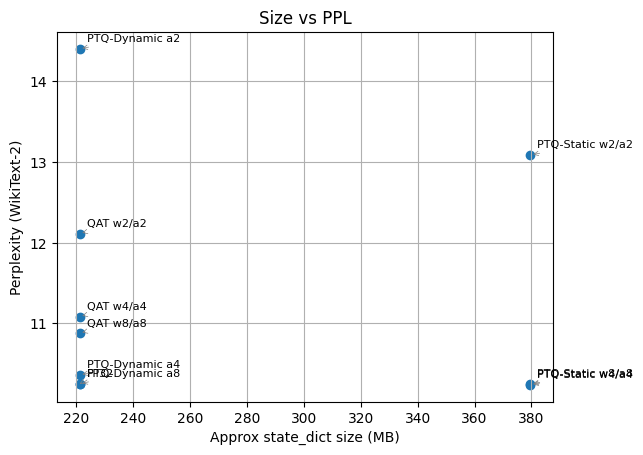

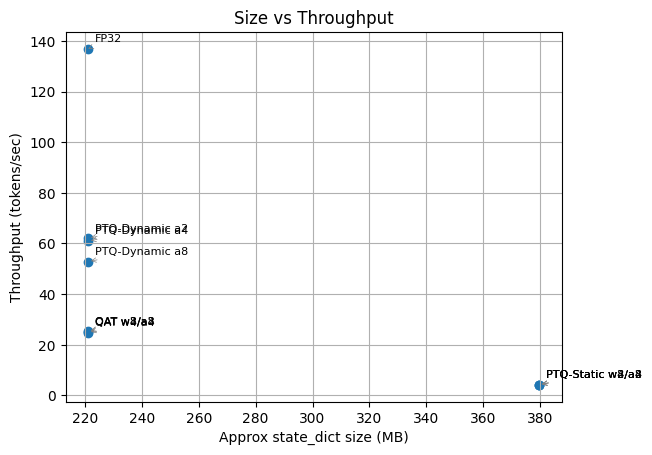

In [12]:
# %% [code]
def plot_results(results):
    # Build arrays
    labels = []
    ppl = []
    thr = []
    size_mb = []
    for r in results:
        lbl = r["method"]
        if r["method"] != "FP32":
            if "w_bits" in r and r["w_bits"]:
                lbl += f" w{r['w_bits']}/a{r['a_bits']}"
            elif "a_bits" in r:
                lbl += f" a{r['a_bits']}"
        labels.append(lbl)
        ppl.append(r["ppl"])
        thr.append(r["throughput_tok_s"])
        size_mb.append(r["model_size_mb_raw"])

    # Size vs PPL
    plt.figure()
    plt.scatter(size_mb, ppl)
    for i, l in enumerate(labels):
        plt.annotate(l, (size_mb[i], ppl[i]),
                     xytext=(5, 5),  # offset
                     textcoords="offset points",
                     fontsize=8,
                     arrowprops=dict(arrowstyle="->", lw=0.5, color="gray"))
    plt.xlabel("Approx state_dict size (MB)")
    plt.ylabel("Perplexity (WikiText-2)")
    plt.title("Size vs PPL")
    plt.grid(True)
    plt.savefig("/content/quant_results/plots/size_vs_ppl.png", dpi=150)
    plt.show()

    # Size vs Throughput
    plt.figure()
    plt.scatter(size_mb, thr)
    for i, l in enumerate(labels):
        plt.annotate(l, (size_mb[i], thr[i]),
                     xytext=(5, 5),  # offset
                     textcoords="offset points",
                     fontsize=8,
                     arrowprops=dict(arrowstyle="->", lw=0.5, color="gray"))
    plt.xlabel("Approx state_dict size (MB)")
    plt.ylabel("Throughput (tokens/sec)")
    plt.title("Size vs Throughput")
    plt.grid(True)
    plt.savefig("/content/quant_results/plots/size_vs_thr.png", dpi=150)
    plt.show()

plot_results(RESULTS)


In [13]:
# %% [code]
def pick_best_tradeoff(results, alpha=0.5):
    """
    alpha in [0,1]: weight for PPL vs throughput in a simple normalized score:
    lower PPL is better, higher throughput better.
    """
    P = [r["ppl"] for r in results]
    T = [r["throughput_tok_s"] for r in results]
    p_min, p_max = min(P), max(P)
    t_min, t_max = min(T), max(T)
    def norm_p(x): return (x - p_min) / max(1e-9, (p_max - p_min))
    def norm_t(x): return (x - t_min) / max(1e-9, (t_max - t_min))
    scored = []
    for r in results:
        score = alpha*(1 - norm_t(r["throughput_tok_s"])) + (1-alpha)*norm_p(r["ppl"])
        # lower is better (we treat (1 - norm_t) so higher thr yields lower penalty)
        scored.append((score, r))
    scored.sort(key=lambda x: x[0])
    return [x[1] for x in scored[:3]]  # top 3

TOP = pick_best_tradeoff(RESULTS, alpha=0.5)
print("Top tradeoffs:")
for r in TOP:
    print({k:r[k] for k in ["method","ppl","throughput_tok_s","model_size_mb_raw","w_bits","a_bits"] if k in r})
with open("/content/quant_results/best_tradeoffs.json","w") as f:
    json.dump(TOP, f, indent=2)

print("Overall tradeoffs:")
for r in RESULTS:
    print({k:r[k] for k in ["method","ppl","throughput_tok_s","model_size_mb_raw","w_bits","a_bits"] if k in r})

Top tradeoffs:
{'method': 'FP32', 'ppl': 10.252974060893116, 'throughput_tok_s': 136.9311110791897, 'model_size_mb_raw': 221.14453125}
{'method': 'PTQ-Dynamic', 'ppl': 10.36413954009545, 'throughput_tok_s': 60.96296775403211, 'model_size_mb_raw': 221.14453125, 'w_bits': None, 'a_bits': 4}
{'method': 'PTQ-Dynamic', 'ppl': 10.255819853182226, 'throughput_tok_s': 52.865046771377976, 'model_size_mb_raw': 221.14453125, 'w_bits': None, 'a_bits': 8}
Overall tradeoffs:
{'method': 'FP32', 'ppl': 10.252974060893116, 'throughput_tok_s': 136.9311110791897, 'model_size_mb_raw': 221.14453125}
{'method': 'PTQ-Dynamic', 'ppl': 10.255819853182226, 'throughput_tok_s': 52.865046771377976, 'model_size_mb_raw': 221.14453125, 'w_bits': None, 'a_bits': 8}
{'method': 'PTQ-Dynamic', 'ppl': 10.36413954009545, 'throughput_tok_s': 60.96296775403211, 'model_size_mb_raw': 221.14453125, 'w_bits': None, 'a_bits': 4}
{'method': 'PTQ-Dynamic', 'ppl': 14.401634529552, 'throughput_tok_s': 62.11139751868587, 'model_size_m

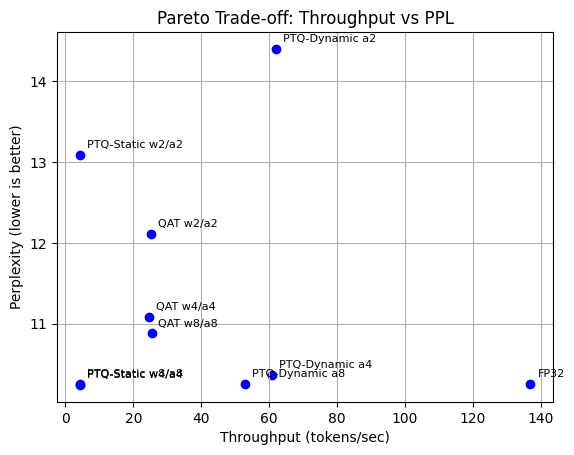

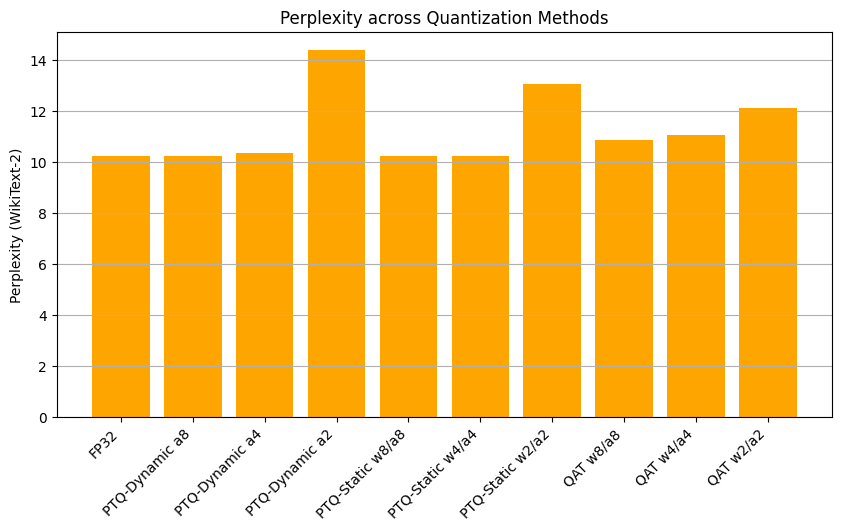

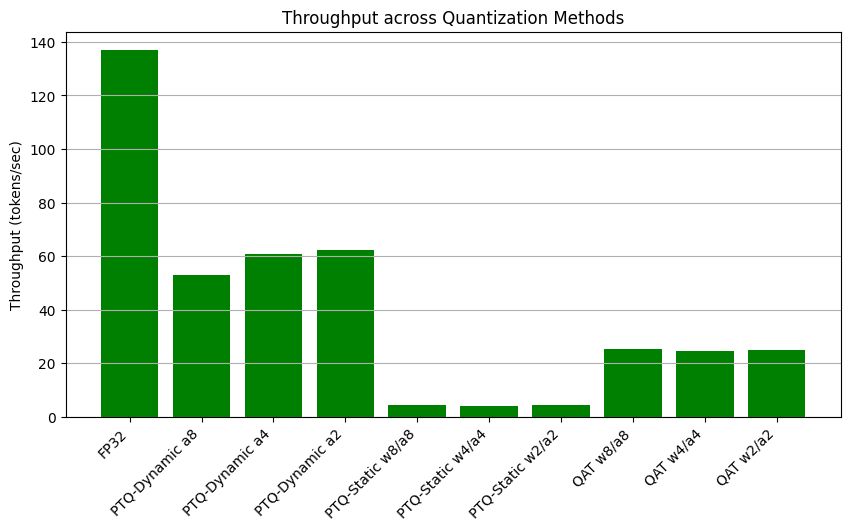

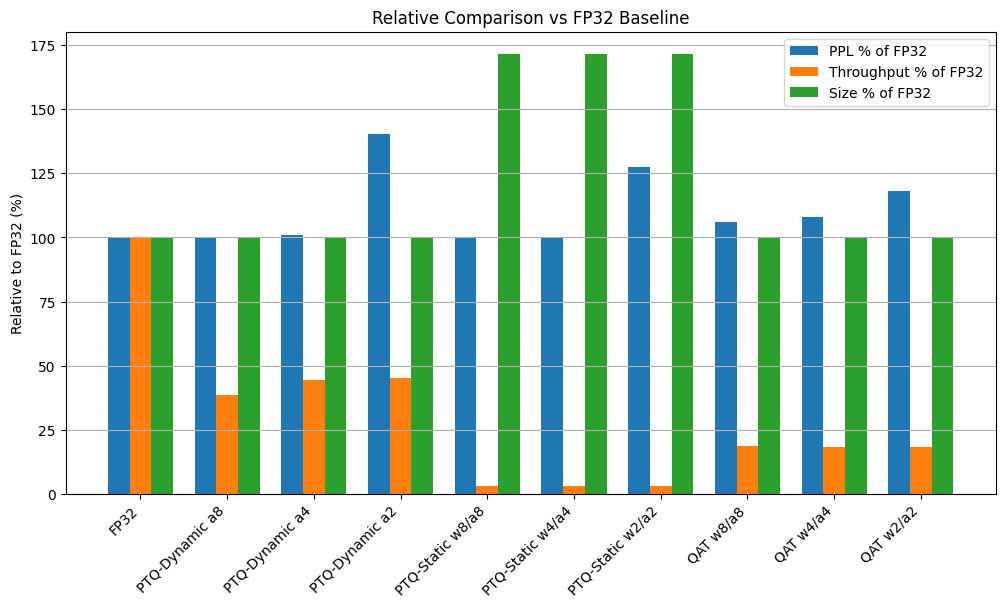

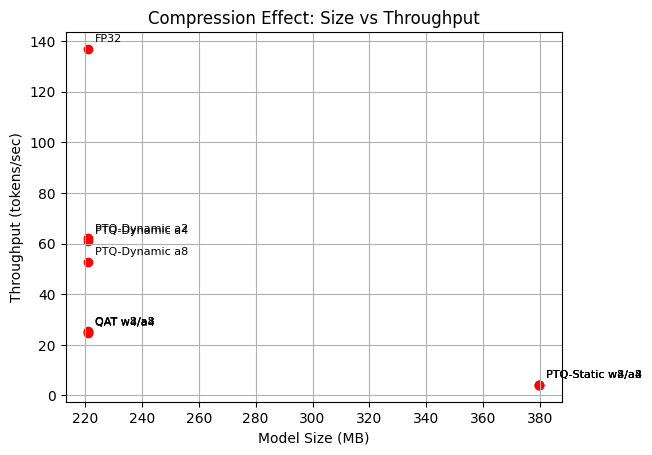

All extended plots saved in /content/quant_results/plots/


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def extended_plots(results):
    labels, ppl, thr, size_mb, methods = [], [], [], [], []
    base_ppl = results[0]["ppl"]
    base_thr = results[0]["throughput_tok_s"]
    base_size = results[0]["model_size_mb_raw"]

    for r in results:
        lbl = r["method"]
        if r["method"] != "FP32":
            if "w_bits" in r and r["w_bits"]:
                lbl += f" w{r['w_bits']}/a{r['a_bits']}"
            elif "a_bits" in r:
                lbl += f" a{r['a_bits']}"
        labels.append(lbl)
        ppl.append(r["ppl"])
        thr.append(r["throughput_tok_s"])
        size_mb.append(r["model_size_mb_raw"])
        methods.append(r["method"])

    # ---------- 1) Pareto Plot: Throughput vs PPL ----------
    plt.figure()
    plt.scatter(thr, ppl, c='blue')
    for i, l in enumerate(labels):
        plt.annotate(l, (thr[i], ppl[i]), xytext=(5, 5), textcoords="offset points", fontsize=8)
    plt.xlabel("Throughput (tokens/sec)")
    plt.ylabel("Perplexity (lower is better)")
    plt.title("Pareto Trade-off: Throughput vs PPL")
    plt.grid(True)
    plt.savefig("/content/quant_results/plots/pareto_thr_vs_ppl.png", dpi=150)
    plt.show()

    # ---------- 2) Bar Chart: Perplexity by Method ----------
    plt.figure(figsize=(10,5))
    plt.bar(labels, ppl, color="orange")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Perplexity (WikiText-2)")
    plt.title("Perplexity across Quantization Methods")
    plt.grid(axis="y")
    plt.savefig("/content/quant_results/plots/bar_ppl.png", dpi=150)
    plt.show()

    # ---------- 3) Bar Chart: Throughput by Method ----------
    plt.figure(figsize=(10,5))
    plt.bar(labels, thr, color="green")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Throughput (tokens/sec)")
    plt.title("Throughput across Quantization Methods")
    plt.grid(axis="y")
    plt.savefig("/content/quant_results/plots/bar_thr.png", dpi=150)
    plt.show()

    # ---------- 4) Relative Improvement (vs FP32) ----------
    rel_ppl = [100 * (p/base_ppl) for p in ppl]          # lower is better
    rel_thr = [100 * (t/base_thr) for t in thr]          # higher is better
    rel_size = [100 * (s/base_size) for s in size_mb]    # lower is better

    x = np.arange(len(labels))
    width = 0.25
    plt.figure(figsize=(12,6))
    plt.bar(x - width, rel_ppl, width, label="PPL % of FP32")
    plt.bar(x, rel_thr, width, label="Throughput % of FP32")
    plt.bar(x + width, rel_size, width, label="Size % of FP32")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Relative to FP32 (%)")
    plt.title("Relative Comparison vs FP32 Baseline")
    plt.legend()
    plt.grid(axis="y")
    plt.savefig("/content/quant_results/plots/relative_vs_fp32.png", dpi=150)
    plt.show()

    # ---------- 5) Size vs Throughput ----------
    plt.figure()
    plt.scatter(size_mb, thr, c="red")
    for i, l in enumerate(labels):
        plt.annotate(l, (size_mb[i], thr[i]), xytext=(5, 5), textcoords="offset points", fontsize=8)
    plt.xlabel("Model Size (MB)")
    plt.ylabel("Throughput (tokens/sec)")
    plt.title("Compression Effect: Size vs Throughput")
    plt.grid(True)
    plt.savefig("/content/quant_results/plots/size_vs_thr_extended.png", dpi=150)
    plt.show()

    print("All extended plots saved in /content/quant_results/plots/")

# Run after RESULTS is ready
extended_plots(RESULTS)
